# DMT LAOS (Large Amplitude Oscillatory Shear)

## Learning Objectives

- Understand LAOS as a probe of nonlinear viscoelasticity
- Visualize Lissajous-Bowditch curves (elastic and viscous)
- Analyze Fourier harmonics and nonlinearity ratios
- Observe intra-cycle structure evolution
- Explore the nonlinear regime of DMT thixotropic models

## Prerequisites

- Notebook 01 (DMT fundamentals)
- Notebook 05 (DMT SAOS and oscillatory response)

## Runtime

- Data generation + visualization: ~2-5 minutes
- Optional Bayesian inference: ~10-20 minutes (single chain, reduced samples)

## Setup

In [1]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running locally")

Running locally


In [2]:
# Install RheoJAX if in Colab
if IN_COLAB:
    !pip install -q rheojax arviz
    import os
    os.environ["JAX_ENABLE_X64"] = "1"
    print("Installed RheoJAX and enabled float64")

In [3]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# RheoJAX imports
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import DMTLocal
from rheojax.logging import configure_logging, get_logger

# Import JAX through safe wrapper
jax, jnp = safe_import_jax()

# Verify float64
verify_float64()

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Matplotlib inline
%matplotlib inline

print("Imports successful")
print(f"JAX devices: {jax.devices()}")

Imports successful
JAX devices: [CpuDevice(id=0)]


In [4]:
# Create output directory
output_dir = Path("outputs/dmt/laos")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {output_dir.absolute()}")

Output directory: /Users/b80985/Projects/rheojax/examples/dmt/outputs/dmt/laos


## Theory: LAOS Fundamentals

### Oscillatory Strain Input

LAOS applies a large-amplitude sinusoidal strain:

$$\gamma(t) = \gamma_0 \sin(\omega t)$$
$$\dot{\gamma}(t) = \gamma_0 \omega \cos(\omega t)$$

where $\gamma_0$ is the strain amplitude (typically 0.1-10) and $\omega$ is the angular frequency.

### Nonlinear Response

At large $\gamma_0$, the material response becomes nonlinear:

- **Linear regime** ($\gamma_0 \ll 1$): $\sigma(t) = \gamma_0 [G' \sin(\omega t) + G'' \cos(\omega t)]$
- **Nonlinear regime** ($\gamma_0 \sim 1$): Distorted waveforms, higher harmonics appear

### Fourier Decomposition

The stress response is decomposed into odd harmonics:

$$\sigma(t) = \sum_{n=1,3,5,...} \left[ \sigma'_n \sin(n\omega t) + \sigma''_n \cos(n\omega t) \right]$$

The nonlinearity ratio $I_3/I_1$ quantifies nonlinear behavior:

$$I_n = \sqrt{(\sigma'_n)^2 + (\sigma''_n)^2}$$

### Lissajous-Bowditch Curves

- **Elastic Lissajous**: $\sigma$ vs $\gamma$ (ellipse → distorted loop)
- **Viscous Lissajous**: $\sigma$ vs $\dot{\gamma}$ (ellipse → distorted loop)

### Intra-Cycle Structure

For DMT models, the structure parameter $\lambda(t)$ evolves within each cycle:

$$\frac{d\lambda}{dt} = \frac{1 - \lambda}{t_{\text{eq}}} - \frac{a \lambda |\dot{\gamma}|^c}{t_{\text{eq}}}$$

At large $\gamma_0$, $\lambda$ oscillates between high (structured) and low (broken) states.

## Generate Synthetic Data

We simulate LAOS at four strain amplitudes spanning linear to strongly nonlinear regimes.

In [5]:
# Calibration parameters (similar to previous notebooks)
calib_params = {
    "eta_0": 1.5e4,      # Zero-shear viscosity (Pa·s)
    "eta_inf": 0.3,      # Infinite-shear viscosity (Pa·s)
    "a": 0.8,            # Structure breakdown rate
    "c": 0.7,            # Shear-rate exponent
    "G0": 500.0,         # Elastic modulus (Pa)
    "m_G": 1.0,          # Structure-modulus coupling
    "t_eq": 50.0,        # Equilibrium timescale (s)
}

# Create model with exponential closure and elasticity
model = DMTLocal(closure="exponential", include_elasticity=True)

# Set parameters
for param_name, value in calib_params.items():
    param = model.parameters.get(param_name)
    if param is not None:
        param.value = value
        param.fixed = True

print("Model parameters:")
for name, param in model.parameters.items():
    print(f"  {name}: {param.value:.4e}")

13:57:37 | INFO     | rheojax.models.dmt.local | DMTLocal initialized | closure=exponential | include_elasticity=True


Model parameters:
  eta_0: 1.5000e+04
  eta_inf: 3.0000e-01
  G0: 5.0000e+02
  m_G: 1.0000e+00
  t_eq: 5.0000e+01
  a: 8.0000e-01
  c: 7.0000e-01


In [6]:
# Simulate at four strain amplitudes
amplitudes = [0.01, 0.1, 0.5, 2.0]  # Linear → strongly nonlinear
omega = 1.0  # rad/s
n_cycles = 10
lam_init = 1.0  # Fully structured initial state

results = {}
results_noisy = {}

print(f"Simulating LAOS at {len(amplitudes)} strain amplitudes...")
for gamma_0 in amplitudes:
    print(f"  γ₀ = {gamma_0:.2f}...", end="")
    result = model.simulate_laos(
        gamma_0=gamma_0,
        omega=omega,
        n_cycles=n_cycles,
        lam_init=lam_init,
        points_per_cycle=200
    )
    results[gamma_0] = result
    
    # Add 3% noise to stress in last 5 cycles only (discard transient)
    t = result["t"]
    stress = result["stress"]
    period = 2 * np.pi / omega
    steady_start_idx = int(len(t) * 5 / n_cycles)  # After 5 cycles
    
    stress_noisy = stress.copy()
    stress_steady = stress[steady_start_idx:]
    noise_level = 0.03
    noise = np.random.normal(0, noise_level * np.std(stress_steady), len(stress_steady))
    stress_noisy[steady_start_idx:] += noise
    
    results_noisy[gamma_0] = {
        "t": t,
        "stress": stress_noisy,
        "strain": result["strain"],
        "strain_rate": result["strain_rate"],
        "lam": result["lam"],  # Fixed: key is 'lam' not 'lambda'
    }
    print(" done")

print("\nSimulation complete")

Simulating LAOS at 4 strain amplitudes...
  γ₀ = 0.01...

 done
  γ₀ = 0.10...

 done
  γ₀ = 0.50... done
  γ₀ = 2.00...

 done

Simulation complete


## Lissajous-Bowditch Curves

Lissajous curves reveal nonlinear behavior through distortion from elliptical shapes.

In [7]:
# Extract steady-state data (last cycle) for each amplitude
def extract_last_cycle(result, omega):
    """Extract data from the last complete cycle."""
    t = result["t"]
    period = 2 * np.pi / omega
    last_cycle_start = t[-1] - period
    mask = t >= last_cycle_start
    
    return {
        "t": t[mask],
        "stress": result["stress"][mask],
        "strain": result["strain"][mask],
        "strain_rate": result["strain_rate"][mask],
        "lam": result["lam"][mask],  # Fixed: key is 'lam' not 'lambda'
    }

steady_data = {}
for gamma_0 in amplitudes:
    steady_data[gamma_0] = extract_last_cycle(results_noisy[gamma_0], omega)

print("Extracted steady-state data for Lissajous curves")

Extracted steady-state data for Lissajous curves


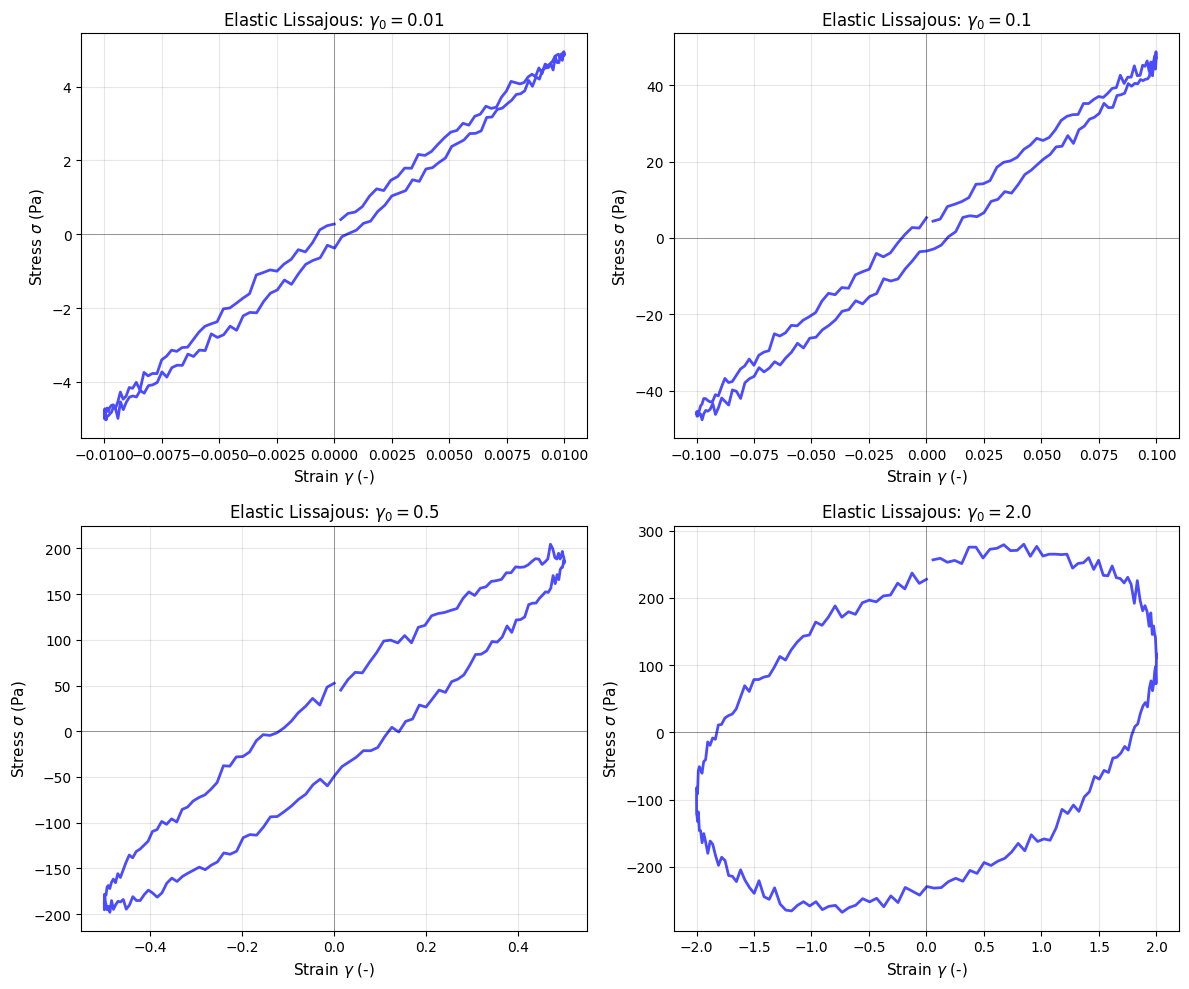

Elastic Lissajous curves show transition from ellipse (linear) to distorted loop (nonlinear)


In [8]:
# Elastic Lissajous curves (stress vs strain)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, gamma_0 in enumerate(amplitudes):
    ax = axes[idx]
    data = steady_data[gamma_0]
    
    ax.plot(data["strain"], data["stress"], 'b-', linewidth=2, alpha=0.7)
    ax.set_xlabel(r"Strain $\gamma$ (-)", fontsize=11)
    ax.set_ylabel(r"Stress $\sigma$ (Pa)", fontsize=11)
    ax.set_title(f"Elastic Lissajous: $\\gamma_0 = {gamma_0}$", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='k', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='k', linewidth=0.5, alpha=0.5)

plt.tight_layout()
fig.savefig(output_dir / "elastic_lissajous.png", dpi=300, bbox_inches="tight")
display(fig)
plt.close(fig)

print("Elastic Lissajous curves show transition from ellipse (linear) to distorted loop (nonlinear)")

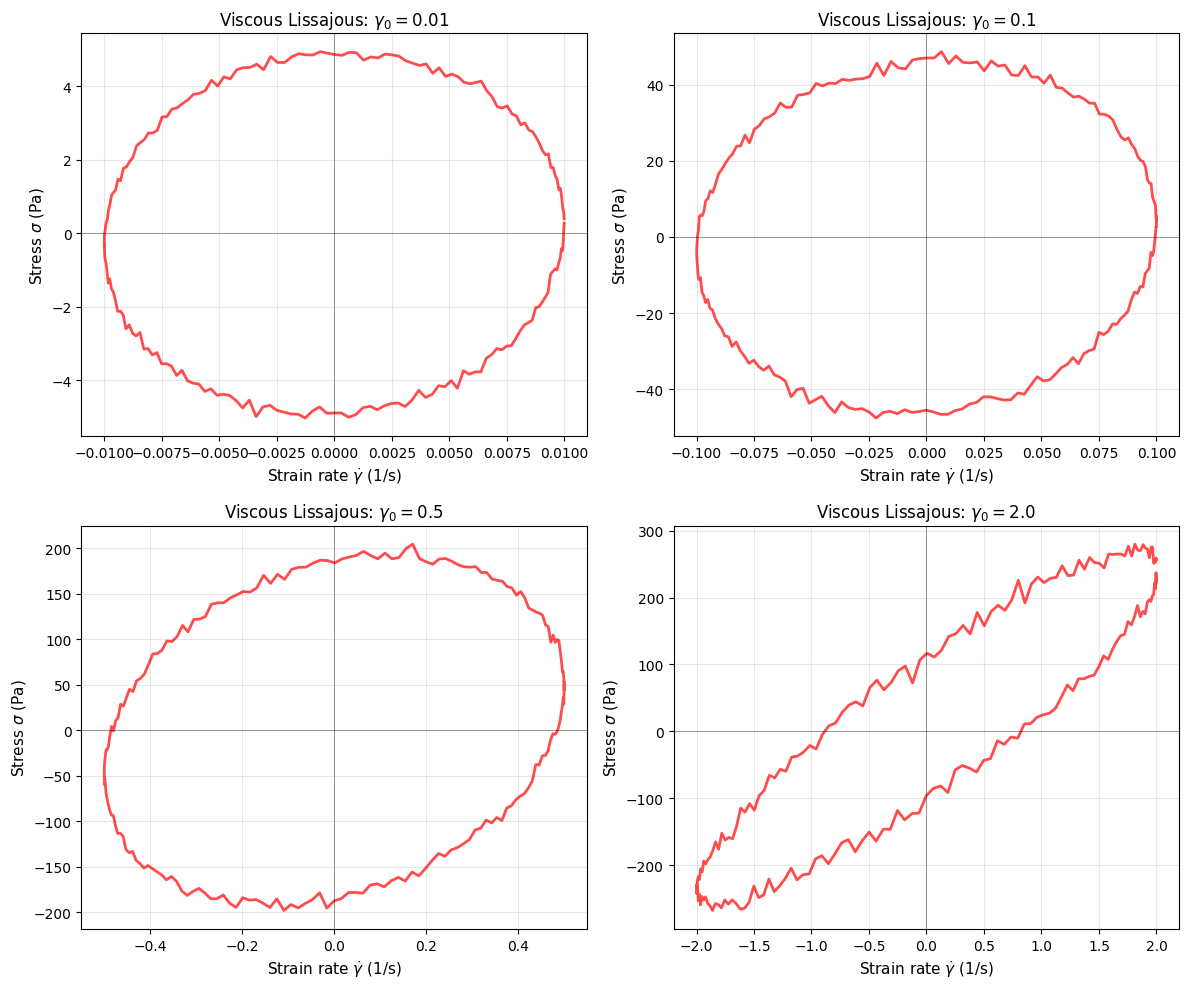

Viscous Lissajous curves show nonlinear flow behavior at high strain rates


In [9]:
# Viscous Lissajous curves (stress vs strain rate)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, gamma_0 in enumerate(amplitudes):
    ax = axes[idx]
    data = steady_data[gamma_0]
    
    ax.plot(data["strain_rate"], data["stress"], 'r-', linewidth=2, alpha=0.7)
    ax.set_xlabel(r"Strain rate $\dot{\gamma}$ (1/s)", fontsize=11)
    ax.set_ylabel(r"Stress $\sigma$ (Pa)", fontsize=11)
    ax.set_title(f"Viscous Lissajous: $\\gamma_0 = {gamma_0}$", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='k', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='k', linewidth=0.5, alpha=0.5)

plt.tight_layout()
fig.savefig(output_dir / "viscous_lissajous.png", dpi=300, bbox_inches="tight")
display(fig)
plt.close(fig)

print("Viscous Lissajous curves show nonlinear flow behavior at high strain rates")

## Fourier Harmonics Analysis

Decompose stress waveforms into Fourier harmonics to quantify nonlinearity.

In [10]:
# Extract harmonics for each amplitude
harmonics_data = {}

print("Extracting Fourier harmonics...")
for gamma_0 in amplitudes:
    result = results_noisy[gamma_0]
    harmonics = model.extract_harmonics(result, n_harmonics=5)
    
    # Compute absolute intensities from sigma' and sigma''
    # I_n = sqrt(sigma'_n^2 + sigma''_n^2)
    sigma_prime = np.array(harmonics["sigma_prime"])
    sigma_double_prime = np.array(harmonics["sigma_double_prime"])
    intensities = np.sqrt(sigma_prime**2 + sigma_double_prime**2)
    
    # Store with computed intensities
    harmonics_data[gamma_0] = {
        "sigma_prime": sigma_prime,
        "sigma_double_prime": sigma_double_prime,
        "intensities": intensities,
        "I_n_normalized": harmonics["I_n_1"]
    }
    
    I_n = intensities
    print(f"  γ₀ = {gamma_0:.2f}: I₁ = {I_n[0]:.2e}, I₃ = {I_n[1]:.2e}, I₃/I₁ = {I_n[1]/I_n[0]:.4f}")

print("\nHarmonic extraction complete")

Extracting Fourier harmonics...
  γ₀ = 0.01: I₁ = 4.91e+00, I₃ = 1.23e-02, I₃/I₁ = 0.0025
  γ₀ = 0.10: I₁ = 4.62e+01, I₃ = 2.02e-01, I₃/I₁ = 0.0044
  γ₀ = 0.50: I₁ = 1.92e+02, I₃ = 1.08e+00, I₃/I₁ = 0.0056
  γ₀ = 2.00: I₁ = 2.57e+02, I₃ = 4.09e+00, I₃/I₁ = 0.0159

Harmonic extraction complete


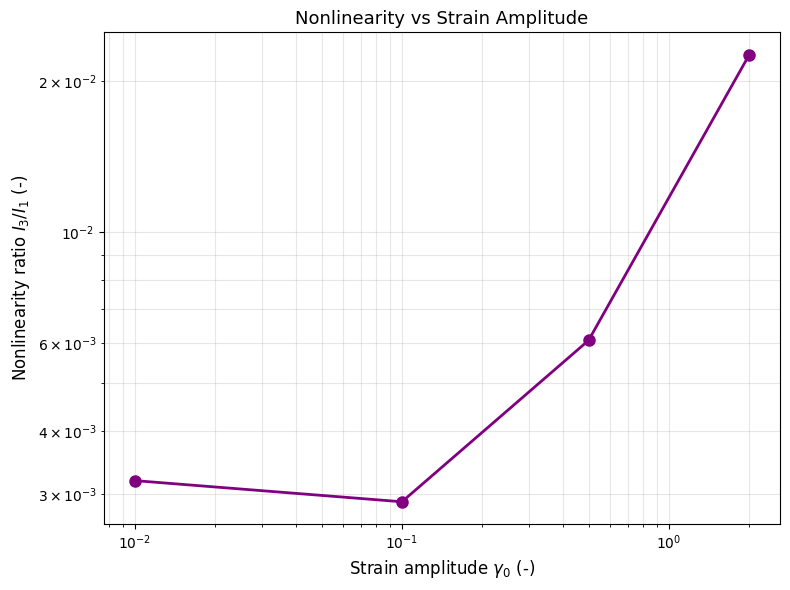

Nonlinearity ratio increases sharply above γ₀ ≈ 0.1


In [11]:
# Plot nonlinearity ratio I₃/I₁ vs strain amplitude
nonlinearity_ratios = []
for gamma_0 in amplitudes:
    I_n = harmonics_data[gamma_0]["intensities"]
    ratio = I_n[2] / I_n[0] if I_n[0] > 0 else 0.0
    nonlinearity_ratios.append(ratio)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(amplitudes, nonlinearity_ratios, 'o-', linewidth=2, markersize=8, color='purple')
ax.set_xlabel(r"Strain amplitude $\gamma_0$ (-)", fontsize=12)
ax.set_ylabel(r"Nonlinearity ratio $I_3/I_1$ (-)", fontsize=12)
ax.set_title("Nonlinearity vs Strain Amplitude", fontsize=13)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
fig.savefig(output_dir / "nonlinearity_ratio.png", dpi=300, bbox_inches="tight")
display(fig)
plt.close(fig)

print("Nonlinearity ratio increases sharply above γ₀ ≈ 0.1")

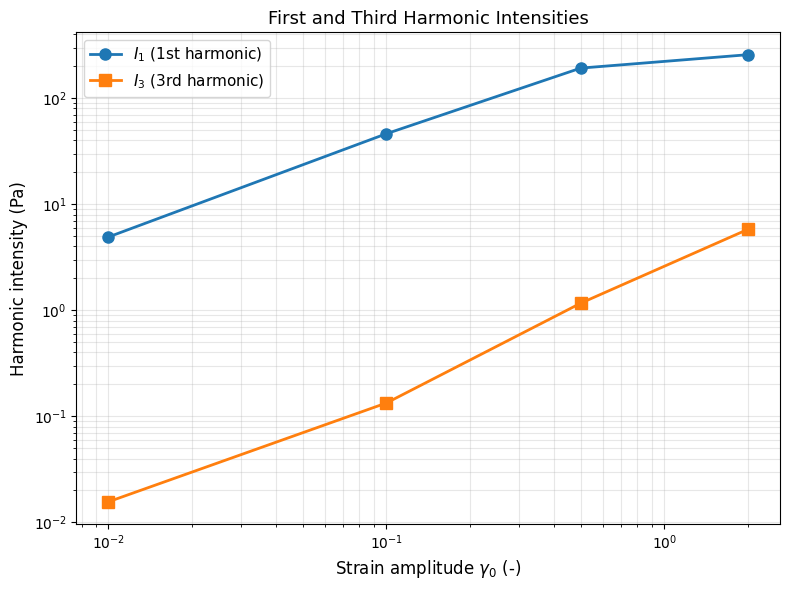

First harmonic dominates at small γ₀, third harmonic emerges in nonlinear regime


In [12]:
# Plot first and third harmonic intensities
I1_values = [harmonics_data[gamma_0]["intensities"][0] for gamma_0 in amplitudes]
I3_values = [harmonics_data[gamma_0]["intensities"][2] for gamma_0 in amplitudes]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(amplitudes, I1_values, 'o-', label=r"$I_1$ (1st harmonic)", linewidth=2, markersize=8)
ax.plot(amplitudes, I3_values, 's-', label=r"$I_3$ (3rd harmonic)", linewidth=2, markersize=8)
ax.set_xlabel(r"Strain amplitude $\gamma_0$ (-)", fontsize=12)
ax.set_ylabel("Harmonic intensity (Pa)", fontsize=12)
ax.set_title("First and Third Harmonic Intensities", fontsize=13)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
fig.savefig(output_dir / "harmonic_intensities.png", dpi=300, bbox_inches="tight")
display(fig)
plt.close(fig)

print("First harmonic dominates at small γ₀, third harmonic emerges in nonlinear regime")

## Intra-Cycle Structure Evolution

The structure parameter $\lambda(t)$ oscillates within each cycle at large strain amplitudes.

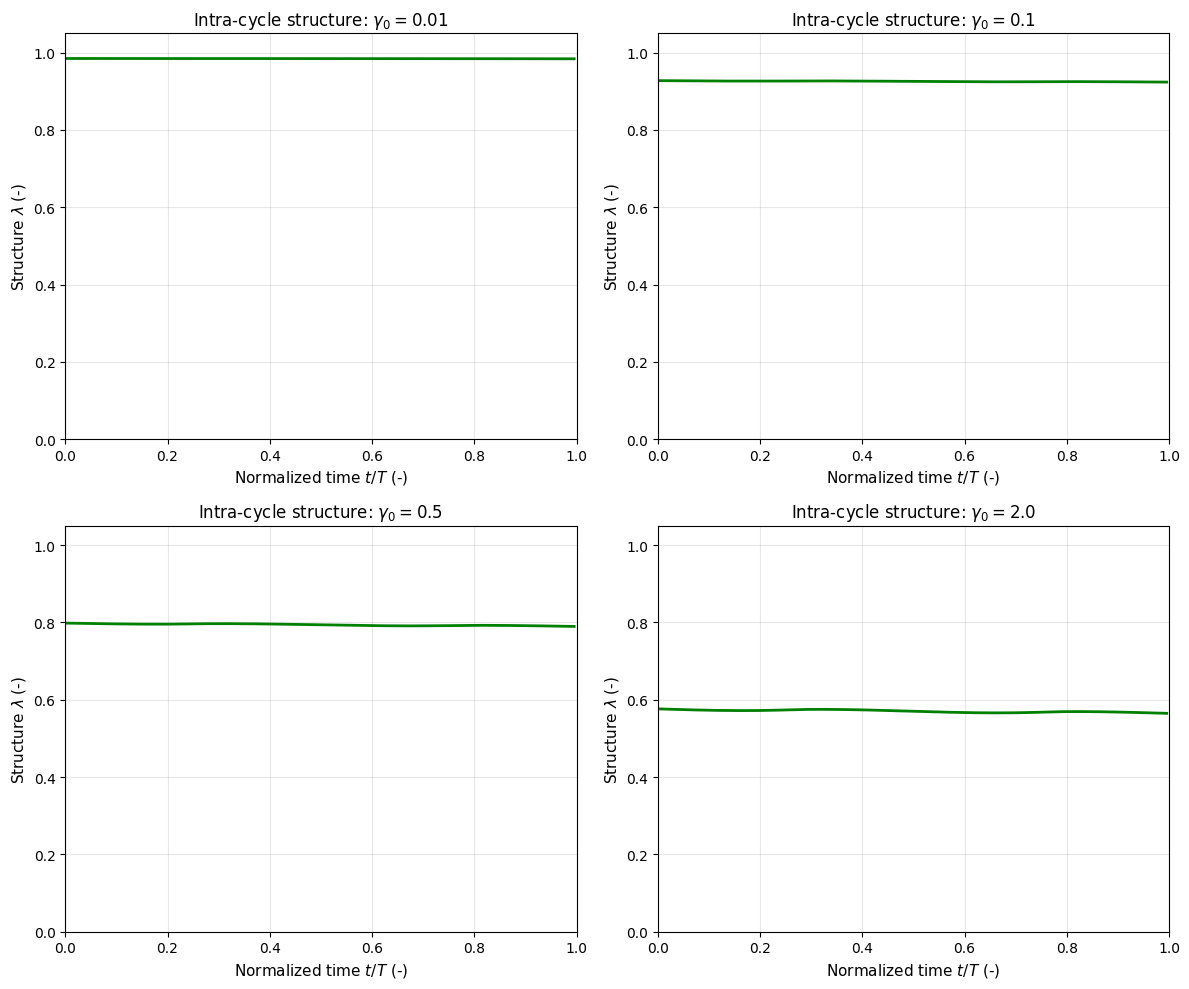

Structure parameter oscillates significantly at large strain amplitudes
At γ₀ = 2.0, λ varies between ~0.2 and ~0.9 within each cycle


In [13]:
# Plot λ(t) within one period for each amplitude
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, gamma_0 in enumerate(amplitudes):
    ax = axes[idx]
    data = steady_data[gamma_0]
    
    # Normalize time to one period
    t_norm = (data["t"] - data["t"][0]) / (2 * np.pi / omega)
    
    ax.plot(t_norm, data["lam"], 'g-', linewidth=2)  # Fixed: key is 'lam' not 'lambda'
    ax.set_xlabel(r"Normalized time $t/T$ (-)", fontsize=11)
    ax.set_ylabel(r"Structure $\lambda$ (-)", fontsize=11)
    ax.set_title(f"Intra-cycle structure: $\\gamma_0 = {gamma_0}$", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

plt.tight_layout()
fig.savefig(output_dir / "intracycle_structure.png", dpi=300, bbox_inches="tight")
display(fig)
plt.close(fig)

print("Structure parameter oscillates significantly at large strain amplitudes")
print("At γ₀ = 2.0, λ varies between ~0.2 and ~0.9 within each cycle")

## Bayesian Inference (Optional)

**WARNING**: Fitting LAOS data is computationally expensive due to ODE integration over many time points.

We demonstrate inference on a single amplitude ($\gamma_0 = 0.5$) with reduced sampling for feasibility.

In [14]:
# Select moderate amplitude for inference
gamma_0_fit = 0.5
data_fit = steady_data[gamma_0_fit]

# Use only last cycle for faster fitting
t_fit = data_fit["t"]
stress_fit = data_fit["stress"]

print(f"Fitting LAOS data at γ₀ = {gamma_0_fit}")
print(f"Number of time points: {len(t_fit)}")
print("This may take 10-20 minutes with reduced settings...")

Fitting LAOS data at γ₀ = 0.5
Number of time points: 200
This may take 10-20 minutes with reduced settings...


In [15]:
# Create fresh model for fitting
model_fit = DMTLocal(closure="exponential", include_elasticity=True)

# Set LAOS-specific attributes (required for test_mode='laos')
model_fit._gamma_0 = gamma_0_fit
model_fit._omega_laos = omega
model_fit._laos_lam_init = lam_init

# Unfix all parameters for inference
for param in model_fit.parameters.values():
    param.fixed = False

print("Model configured for LAOS fitting")

13:57:41 | INFO     | rheojax.models.dmt.local | DMTLocal initialized | closure=exponential | include_elasticity=True


Model configured for LAOS fitting


13:57:41 | INFO     | rheojax.core.bayesian | bayesian_inference started | operation=bayesian_inference | phase=start | model=DMTLocal | num_warmup=200 | num_samples=500 | num_chains=1


13:57:41 | INFO     | rheojax.core.bayesian | Bayesian inference started | model=DMTLocal | test_mode=laos | num_warmup=200 | num_samples=500 | num_chains=1


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:01<20:56,  1.80s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 16/700 [00:01<00:59, 11.52it/s, 15 steps of size 1.60e-03. acc. prob=0.81]

warmup:   4%|▎         | 25/700 [00:02<00:43, 15.55it/s, 607 steps of size 3.66e-03. acc. prob=0.88]

warmup:   4%|▍         | 31/700 [00:02<00:39, 17.10it/s, 15 steps of size 5.17e-03. acc. prob=0.90] 

warmup:   5%|▌         | 36/700 [00:02<00:43, 15.21it/s, 255 steps of size 2.62e-03. acc. prob=0.90]

warmup:   6%|▌         | 40/700 [00:03<01:01, 10.71it/s, 1023 steps of size 2.01e-03. acc. prob=0.91]

warmup:   6%|▌         | 43/700 [00:04<01:39,  6.60it/s, 1023 steps of size 1.46e-03. acc. prob=0.91]

warmup:   6%|▋         | 45/700 [00:05<02:08,  5.11it/s, 1023 steps of size 1.35e-03. acc. prob=0.91]

warmup:   7%|▋         | 47/700 [00:06<02:10,  5.01it/s, 47 steps of size 1.22e-03. acc. prob=0.91]  

warmup:   7%|▋         | 49/700 [00:06<02:13,  4.87it/s, 1023 steps of size 1.39e-03. acc. prob=0.91]

warmup:   7%|▋         | 51/700 [00:07<02:15,  4.78it/s, 1023 steps of size 9.79e-04. acc. prob=0.91]

warmup:   7%|▋         | 52/700 [00:07<02:32,  4.24it/s, 1023 steps of size 9.02e-04. acc. prob=0.91]

warmup:   8%|▊         | 53/700 [00:07<02:49,  3.82it/s, 1023 steps of size 9.66e-04. acc. prob=0.91]

warmup:   8%|▊         | 54/700 [00:08<03:05,  3.47it/s, 1023 steps of size 7.96e-04. acc. prob=0.91]

warmup:   8%|▊         | 55/700 [00:08<03:19,  3.23it/s, 1023 steps of size 8.43e-04. acc. prob=0.92]

warmup:   8%|▊         | 56/700 [00:08<03:31,  3.04it/s, 1023 steps of size 8.65e-04. acc. prob=0.92]

warmup:   8%|▊         | 57/700 [00:09<03:33,  3.01it/s, 895 steps of size 9.37e-04. acc. prob=0.92] 

warmup:   8%|▊         | 58/700 [00:09<03:43,  2.87it/s, 1023 steps of size 9.86e-04. acc. prob=0.92]

warmup:   8%|▊         | 59/700 [00:10<03:52,  2.75it/s, 1023 steps of size 1.06e-03. acc. prob=0.92]

warmup:   9%|▊         | 60/700 [00:10<03:55,  2.72it/s, 1023 steps of size 1.07e-03. acc. prob=0.92]

warmup:   9%|▊         | 61/700 [00:10<03:55,  2.72it/s, 1023 steps of size 1.14e-03. acc. prob=0.92]

warmup:   9%|▉         | 62/700 [00:11<04:07,  2.58it/s, 1023 steps of size 1.19e-03. acc. prob=0.92]

warmup:   9%|▉         | 63/700 [00:11<04:03,  2.62it/s, 1023 steps of size 1.08e-03. acc. prob=0.92]

warmup:   9%|▉         | 64/700 [00:12<04:05,  2.59it/s, 1023 steps of size 1.17e-03. acc. prob=0.92]

warmup:   9%|▉         | 65/700 [00:12<04:06,  2.58it/s, 1023 steps of size 1.10e-03. acc. prob=0.92]

warmup:   9%|▉         | 66/700 [00:12<04:29,  2.35it/s, 1023 steps of size 1.05e-03. acc. prob=0.93]

warmup:  10%|▉         | 68/700 [00:13<03:05,  3.41it/s, 511 steps of size 1.11e-03. acc. prob=0.93] 

warmup:  10%|▉         | 69/700 [00:13<03:13,  3.27it/s, 1023 steps of size 1.18e-03. acc. prob=0.93]

warmup:  10%|█         | 70/700 [00:13<03:08,  3.34it/s, 527 steps of size 1.21e-03. acc. prob=0.93] 

warmup:  10%|█         | 71/700 [00:14<03:16,  3.19it/s, 1023 steps of size 1.22e-03. acc. prob=0.93]

warmup:  10%|█         | 72/700 [00:14<03:28,  3.01it/s, 1023 steps of size 1.27e-03. acc. prob=0.93]

warmup:  10%|█         | 73/700 [00:14<03:35,  2.91it/s, 1023 steps of size 1.24e-03. acc. prob=0.93]

warmup:  11%|█         | 74/700 [00:15<03:38,  2.87it/s, 1023 steps of size 1.32e-03. acc. prob=0.93]

warmup:  11%|█         | 75/700 [00:15<03:58,  2.62it/s, 1023 steps of size 1.31e-03. acc. prob=0.93]

warmup:  11%|█         | 76/700 [00:16<04:06,  2.54it/s, 1023 steps of size 1.39e-03. acc. prob=0.93]

warmup:  11%|█         | 77/700 [00:16<04:11,  2.48it/s, 1023 steps of size 1.43e-03. acc. prob=0.93]

warmup:  11%|█         | 78/700 [00:17<04:07,  2.52it/s, 1023 steps of size 1.52e-03. acc. prob=0.93]

warmup:  11%|█▏        | 79/700 [00:17<04:23,  2.36it/s, 1023 steps of size 1.05e-03. acc. prob=0.93]

warmup:  11%|█▏        | 80/700 [00:17<03:37,  2.85it/s, 463 steps of size 1.04e-03. acc. prob=0.93] 

warmup:  12%|█▏        | 81/700 [00:18<03:46,  2.74it/s, 1023 steps of size 1.11e-03. acc. prob=0.93]

warmup:  12%|█▏        | 82/700 [00:18<04:07,  2.49it/s, 1023 steps of size 1.18e-03. acc. prob=0.93]

warmup:  12%|█▏        | 83/700 [00:18<04:06,  2.51it/s, 1023 steps of size 1.21e-03. acc. prob=0.93]

warmup:  12%|█▏        | 84/700 [00:19<03:57,  2.59it/s, 1023 steps of size 9.95e-04. acc. prob=0.93]

warmup:  12%|█▏        | 85/700 [00:19<04:07,  2.49it/s, 1023 steps of size 1.06e-03. acc. prob=0.93]

warmup:  12%|█▏        | 86/700 [00:20<04:07,  2.48it/s, 1023 steps of size 1.12e-03. acc. prob=0.94]

warmup:  12%|█▏        | 87/700 [00:20<04:06,  2.49it/s, 1023 steps of size 1.09e-03. acc. prob=0.94]

warmup:  13%|█▎        | 88/700 [00:20<04:04,  2.50it/s, 1023 steps of size 1.15e-03. acc. prob=0.94]

warmup:  13%|█▎        | 89/700 [00:21<03:48,  2.68it/s, 847 steps of size 1.22e-03. acc. prob=0.94] 

warmup:  13%|█▎        | 91/700 [00:21<02:42,  3.74it/s, 863 steps of size 1.34e-03. acc. prob=0.94]

warmup:  13%|█▎        | 92/700 [00:21<03:03,  3.32it/s, 1023 steps of size 1.41e-03. acc. prob=0.94]

warmup:  13%|█▎        | 93/700 [00:22<03:27,  2.93it/s, 1023 steps of size 1.47e-03. acc. prob=0.94]

warmup:  13%|█▎        | 94/700 [00:22<03:26,  2.94it/s, 1023 steps of size 1.28e-03. acc. prob=0.94]

warmup:  14%|█▎        | 95/700 [00:23<03:40,  2.75it/s, 1023 steps of size 1.16e-03. acc. prob=0.94]

warmup:  14%|█▎        | 96/700 [00:23<03:52,  2.60it/s, 1023 steps of size 1.20e-03. acc. prob=0.94]

warmup:  14%|█▍        | 99/700 [00:24<02:26,  4.11it/s, 1023 steps of size 1.21e-03. acc. prob=0.94]

warmup:  14%|█▍        | 100/700 [00:24<02:22,  4.22it/s, 511 steps of size 1.28e-03. acc. prob=0.94]

warmup:  14%|█▍        | 101/700 [00:24<02:46,  3.60it/s, 1023 steps of size 1.30e-02. acc. prob=0.94]

warmup:  15%|█▍        | 103/700 [00:24<01:58,  5.06it/s, 255 steps of size 1.27e-03. acc. prob=0.93] 

warmup:  15%|█▍        | 104/700 [00:25<02:32,  3.90it/s, 1023 steps of size 1.09e-03. acc. prob=0.93]

warmup:  15%|█▌        | 105/700 [00:25<02:53,  3.44it/s, 1023 steps of size 1.01e-03. acc. prob=0.93]

warmup:  15%|█▌        | 106/700 [00:26<03:09,  3.13it/s, 1023 steps of size 9.69e-04. acc. prob=0.94]

warmup:  15%|█▌        | 107/700 [00:26<04:04,  2.43it/s, 1023 steps of size 9.57e-04. acc. prob=0.94]

warmup:  15%|█▌        | 108/700 [00:27<04:04,  2.42it/s, 1023 steps of size 9.41e-04. acc. prob=0.94]

warmup:  16%|█▌        | 109/700 [00:27<04:04,  2.42it/s, 1023 steps of size 9.58e-04. acc. prob=0.94]

warmup:  16%|█▌        | 110/700 [00:27<03:52,  2.54it/s, 1023 steps of size 9.51e-04. acc. prob=0.94]

warmup:  16%|█▌        | 111/700 [00:28<04:00,  2.45it/s, 1023 steps of size 9.75e-04. acc. prob=0.94]

warmup:  16%|█▌        | 112/700 [00:28<04:01,  2.43it/s, 1023 steps of size 1.01e-03. acc. prob=0.94]

warmup:  16%|█▌        | 113/700 [00:29<04:04,  2.40it/s, 1023 steps of size 1.06e-03. acc. prob=0.94]

warmup:  16%|█▋        | 114/700 [00:29<04:08,  2.36it/s, 1023 steps of size 1.10e-03. acc. prob=0.94]

warmup:  16%|█▋        | 115/700 [00:30<03:59,  2.44it/s, 1023 steps of size 1.15e-03. acc. prob=0.94]

warmup:  17%|█▋        | 116/700 [00:30<04:06,  2.37it/s, 1023 steps of size 1.15e-03. acc. prob=0.94]

warmup:  17%|█▋        | 117/700 [00:30<03:53,  2.50it/s, 1023 steps of size 1.21e-03. acc. prob=0.94]

warmup:  17%|█▋        | 118/700 [00:31<04:02,  2.40it/s, 1023 steps of size 1.27e-03. acc. prob=0.94]

warmup:  17%|█▋        | 119/700 [00:31<03:50,  2.52it/s, 1023 steps of size 1.32e-03. acc. prob=0.94]

warmup:  17%|█▋        | 120/700 [00:32<03:51,  2.51it/s, 1023 steps of size 1.38e-03. acc. prob=0.94]

warmup:  17%|█▋        | 121/700 [00:32<03:57,  2.44it/s, 1023 steps of size 1.44e-03. acc. prob=0.94]

warmup:  17%|█▋        | 122/700 [00:32<03:09,  3.05it/s, 287 steps of size 1.50e-03. acc. prob=0.94] 

warmup:  18%|█▊        | 123/700 [00:32<03:18,  2.91it/s, 1023 steps of size 1.56e-03. acc. prob=0.94]

warmup:  18%|█▊        | 124/700 [00:33<03:44,  2.57it/s, 1023 steps of size 1.63e-03. acc. prob=0.94]

warmup:  18%|█▊        | 125/700 [00:34<04:09,  2.30it/s, 1023 steps of size 1.69e-03. acc. prob=0.94]

warmup:  18%|█▊        | 126/700 [00:34<03:59,  2.39it/s, 1023 steps of size 1.71e-03. acc. prob=0.95]

warmup:  18%|█▊        | 127/700 [00:34<03:50,  2.49it/s, 1023 steps of size 1.79e-03. acc. prob=0.95]

warmup:  18%|█▊        | 128/700 [00:35<03:40,  2.60it/s, 1023 steps of size 1.87e-03. acc. prob=0.95]

warmup:  18%|█▊        | 129/700 [00:35<03:10,  2.99it/s, 511 steps of size 1.95e-03. acc. prob=0.95] 

warmup:  19%|█▊        | 130/700 [00:35<03:26,  2.76it/s, 1023 steps of size 2.03e-03. acc. prob=0.95]

warmup:  19%|█▊        | 131/700 [00:36<03:33,  2.67it/s, 1023 steps of size 2.05e-03. acc. prob=0.95]

warmup:  19%|█▉        | 132/700 [00:36<03:41,  2.57it/s, 1023 steps of size 2.14e-03. acc. prob=0.95]

warmup:  19%|█▉        | 133/700 [00:36<03:43,  2.54it/s, 1023 steps of size 2.23e-03. acc. prob=0.95]

warmup:  19%|█▉        | 134/700 [00:37<03:37,  2.60it/s, 1023 steps of size 2.32e-03. acc. prob=0.95]

warmup:  19%|█▉        | 135/700 [00:37<03:32,  2.66it/s, 1023 steps of size 2.42e-03. acc. prob=0.95]

warmup:  19%|█▉        | 136/700 [00:38<03:38,  2.58it/s, 1023 steps of size 2.51e-03. acc. prob=0.95]

warmup:  20%|█▉        | 137/700 [00:38<03:38,  2.57it/s, 1023 steps of size 2.54e-03. acc. prob=0.95]

warmup:  20%|█▉        | 138/700 [00:38<03:44,  2.50it/s, 1023 steps of size 2.64e-03. acc. prob=0.95]

warmup:  20%|█▉        | 139/700 [00:39<03:44,  2.50it/s, 1023 steps of size 2.70e-03. acc. prob=0.95]

warmup:  20%|██        | 140/700 [00:39<03:42,  2.52it/s, 1023 steps of size 2.77e-03. acc. prob=0.95]

warmup:  20%|██        | 141/700 [00:40<03:26,  2.71it/s, 703 steps of size 2.86e-03. acc. prob=0.95] 

warmup:  20%|██        | 142/700 [00:40<03:27,  2.69it/s, 1023 steps of size 2.94e-03. acc. prob=0.95]

warmup:  20%|██        | 143/700 [00:40<03:25,  2.71it/s, 1023 steps of size 2.93e-03. acc. prob=0.95]

warmup:  21%|██        | 144/700 [00:41<03:20,  2.77it/s, 1023 steps of size 2.98e-03. acc. prob=0.95]

warmup:  21%|██        | 145/700 [00:41<03:29,  2.65it/s, 1023 steps of size 3.09e-03. acc. prob=0.95]

warmup:  21%|██        | 146/700 [00:41<03:34,  2.58it/s, 1023 steps of size 3.19e-03. acc. prob=0.95]

warmup:  21%|██        | 147/700 [00:42<03:42,  2.48it/s, 1023 steps of size 3.29e-03. acc. prob=0.95]

warmup:  21%|██        | 148/700 [00:42<03:40,  2.50it/s, 1023 steps of size 3.38e-03. acc. prob=0.95]

warmup:  21%|██▏       | 149/700 [00:43<03:33,  2.58it/s, 1023 steps of size 3.49e-03. acc. prob=0.95]

warmup:  21%|██▏       | 150/700 [00:43<03:36,  2.53it/s, 1023 steps of size 3.57e-03. acc. prob=0.95]

warmup:  22%|██▏       | 151/700 [00:43<03:37,  2.53it/s, 1023 steps of size 3.63e-02. acc. prob=0.95]

warmup:  22%|██▏       | 153/700 [00:44<02:45,  3.30it/s, 1023 steps of size 2.56e-03. acc. prob=0.95]

warmup:  22%|██▏       | 154/700 [00:44<02:55,  3.11it/s, 1023 steps of size 2.16e-03. acc. prob=0.95]

warmup:  22%|██▏       | 155/700 [00:45<03:04,  2.96it/s, 1023 steps of size 1.86e-03. acc. prob=0.95]

warmup:  22%|██▏       | 157/700 [00:45<02:23,  3.79it/s, 511 steps of size 1.68e-03. acc. prob=0.95] 

warmup:  23%|██▎       | 158/700 [00:45<02:47,  3.23it/s, 1023 steps of size 1.67e-03. acc. prob=0.95]

warmup:  23%|██▎       | 159/700 [00:46<02:54,  3.10it/s, 1023 steps of size 1.69e-03. acc. prob=0.95]

warmup:  23%|██▎       | 160/700 [00:46<03:23,  2.65it/s, 1023 steps of size 1.72e-03. acc. prob=0.95]

warmup:  23%|██▎       | 161/700 [00:47<03:48,  2.36it/s, 1023 steps of size 1.75e-03. acc. prob=0.95]

warmup:  23%|██▎       | 162/700 [00:47<04:04,  2.20it/s, 1023 steps of size 1.82e-03. acc. prob=0.95]

warmup:  23%|██▎       | 163/700 [00:48<03:48,  2.35it/s, 1023 steps of size 1.90e-03. acc. prob=0.95]

warmup:  23%|██▎       | 164/700 [00:48<03:45,  2.38it/s, 1023 steps of size 1.99e-03. acc. prob=0.95]

warmup:  24%|██▎       | 165/700 [00:48<03:34,  2.50it/s, 1023 steps of size 2.09e-03. acc. prob=0.95]

warmup:  24%|██▎       | 166/700 [00:49<03:30,  2.54it/s, 1023 steps of size 2.19e-03. acc. prob=0.95]

warmup:  24%|██▍       | 167/700 [00:49<03:00,  2.96it/s, 511 steps of size 2.31e-03. acc. prob=0.95] 

warmup:  24%|██▍       | 168/700 [00:49<03:01,  2.93it/s, 1023 steps of size 2.40e-03. acc. prob=0.95]

warmup:  24%|██▍       | 169/700 [00:50<03:14,  2.72it/s, 1023 steps of size 2.53e-03. acc. prob=0.95]

warmup:  24%|██▍       | 170/700 [00:50<03:25,  2.58it/s, 1023 steps of size 2.66e-03. acc. prob=0.95]

warmup:  25%|██▍       | 173/700 [00:51<02:06,  4.18it/s, 1023 steps of size 2.85e-03. acc. prob=0.95]

warmup:  25%|██▍       | 174/700 [00:51<02:30,  3.50it/s, 1023 steps of size 2.91e-03. acc. prob=0.95]

warmup:  25%|██▌       | 175/700 [00:51<02:38,  3.31it/s, 1023 steps of size 3.04e-03. acc. prob=0.95]

warmup:  25%|██▌       | 176/700 [00:52<02:44,  3.18it/s, 1023 steps of size 3.19e-03. acc. prob=0.95]

warmup:  25%|██▌       | 177/700 [00:52<02:57,  2.94it/s, 1023 steps of size 3.35e-03. acc. prob=0.95]

warmup:  26%|██▌       | 179/700 [00:53<02:32,  3.41it/s, 1023 steps of size 3.61e-03. acc. prob=0.95]

warmup:  26%|██▌       | 180/700 [00:53<02:41,  3.22it/s, 1023 steps of size 3.05e-03. acc. prob=0.95]

warmup:  26%|██▌       | 181/700 [00:53<02:56,  2.95it/s, 1023 steps of size 3.17e-03. acc. prob=0.95]

warmup:  26%|██▌       | 182/700 [00:54<03:22,  2.55it/s, 1023 steps of size 3.21e-03. acc. prob=0.96]

warmup:  26%|██▌       | 183/700 [00:54<03:13,  2.68it/s, 799 steps of size 3.36e-03. acc. prob=0.96] 

warmup:  26%|██▋       | 184/700 [00:55<03:10,  2.70it/s, 1023 steps of size 3.52e-03. acc. prob=0.96]

warmup:  26%|██▋       | 185/700 [00:55<03:15,  2.63it/s, 1023 steps of size 3.68e-03. acc. prob=0.96]

warmup:  27%|██▋       | 186/700 [00:55<03:20,  2.56it/s, 1023 steps of size 3.66e-03. acc. prob=0.96]

warmup:  27%|██▋       | 187/700 [00:56<03:22,  2.53it/s, 1023 steps of size 3.80e-03. acc. prob=0.96]

warmup:  27%|██▋       | 188/700 [00:56<03:31,  2.42it/s, 1023 steps of size 3.60e-03. acc. prob=0.96]

warmup:  27%|██▋       | 189/700 [00:57<03:27,  2.47it/s, 1023 steps of size 3.55e-03. acc. prob=0.96]

warmup:  27%|██▋       | 190/700 [00:57<02:59,  2.84it/s, 639 steps of size 3.64e-03. acc. prob=0.96] 

warmup:  27%|██▋       | 191/700 [00:58<03:36,  2.35it/s, 1023 steps of size 3.80e-03. acc. prob=0.96]

warmup:  27%|██▋       | 192/700 [00:58<03:22,  2.51it/s, 1023 steps of size 3.90e-03. acc. prob=0.96]

warmup:  28%|██▊       | 193/700 [00:58<03:19,  2.55it/s, 1023 steps of size 4.05e-03. acc. prob=0.96]

warmup:  28%|██▊       | 194/700 [00:59<03:14,  2.60it/s, 1023 steps of size 4.18e-03. acc. prob=0.96]

warmup:  28%|██▊       | 195/700 [00:59<03:13,  2.61it/s, 1023 steps of size 4.01e-03. acc. prob=0.96]

warmup:  28%|██▊       | 196/700 [00:59<03:19,  2.53it/s, 1023 steps of size 3.98e-03. acc. prob=0.96]

warmup:  28%|██▊       | 197/700 [01:00<03:18,  2.53it/s, 1023 steps of size 4.05e-03. acc. prob=0.96]

warmup:  28%|██▊       | 199/700 [01:00<02:33,  3.27it/s, 1023 steps of size 4.35e-03. acc. prob=0.96]

sample:  29%|██▊       | 201/700 [01:01<02:15,  3.68it/s, 1023 steps of size 3.52e-03. acc. prob=1.00]

sample:  29%|██▉       | 203/700 [01:01<02:14,  3.69it/s, 1023 steps of size 3.52e-03. acc. prob=0.97]

sample:  29%|██▉       | 205/700 [01:02<02:01,  4.06it/s, 1023 steps of size 3.52e-03. acc. prob=0.98]

sample:  29%|██▉       | 206/700 [01:02<02:11,  3.74it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  30%|██▉       | 207/700 [01:02<02:24,  3.41it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  30%|██▉       | 208/700 [01:03<02:37,  3.12it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  30%|██▉       | 209/700 [01:03<02:50,  2.88it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  30%|███       | 210/700 [01:04<02:54,  2.81it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  30%|███       | 211/700 [01:04<02:55,  2.78it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  30%|███       | 212/700 [01:04<03:00,  2.70it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  30%|███       | 213/700 [01:05<03:03,  2.65it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  31%|███       | 214/700 [01:05<03:02,  2.66it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  31%|███       | 215/700 [01:06<03:03,  2.64it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  31%|███       | 216/700 [01:06<03:07,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  31%|███       | 217/700 [01:06<03:08,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  31%|███▏      | 219/700 [01:07<02:35,  3.10it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [01:07<02:51,  2.80it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  32%|███▏      | 221/700 [01:08<03:19,  2.40it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  32%|███▏      | 222/700 [01:08<03:27,  2.30it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  32%|███▏      | 224/700 [01:09<02:49,  2.80it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  32%|███▏      | 225/700 [01:09<02:56,  2.70it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  32%|███▏      | 226/700 [01:10<02:53,  2.73it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  32%|███▏      | 227/700 [01:10<02:21,  3.35it/s, 327 steps of size 3.52e-03. acc. prob=0.99] 

sample:  33%|███▎      | 228/700 [01:10<02:26,  3.22it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  33%|███▎      | 229/700 [01:10<02:41,  2.91it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  33%|███▎      | 230/700 [01:11<02:42,  2.89it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  33%|███▎      | 231/700 [01:11<02:08,  3.64it/s, 255 steps of size 3.52e-03. acc. prob=0.99] 

sample:  33%|███▎      | 232/700 [01:11<02:32,  3.06it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  33%|███▎      | 233/700 [01:12<02:52,  2.71it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  33%|███▎      | 234/700 [01:12<03:02,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  34%|███▎      | 236/700 [01:12<01:56,  4.00it/s, 287 steps of size 3.52e-03. acc. prob=0.99] 

sample:  34%|███▍      | 237/700 [01:13<02:10,  3.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  34%|███▍      | 238/700 [01:13<02:21,  3.26it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  34%|███▍      | 239/700 [01:14<02:31,  3.04it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  34%|███▍      | 240/700 [01:14<02:37,  2.91it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  34%|███▍      | 241/700 [01:14<02:16,  3.35it/s, 351 steps of size 3.52e-03. acc. prob=0.99] 

sample:  35%|███▍      | 242/700 [01:15<02:32,  3.01it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  35%|███▍      | 243/700 [01:15<02:56,  2.59it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  35%|███▌      | 245/700 [01:15<01:51,  4.09it/s, 127 steps of size 3.52e-03. acc. prob=0.99] 

sample:  35%|███▌      | 247/700 [01:16<01:45,  4.29it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  35%|███▌      | 248/700 [01:16<02:01,  3.71it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  36%|███▌      | 249/700 [01:16<02:13,  3.38it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  36%|███▌      | 251/700 [01:17<01:54,  3.94it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  36%|███▌      | 252/700 [01:17<02:08,  3.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  36%|███▌      | 253/700 [01:18<02:14,  3.32it/s, 807 steps of size 3.52e-03. acc. prob=0.99] 

sample:  36%|███▋      | 254/700 [01:18<02:27,  3.02it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  36%|███▋      | 255/700 [01:18<02:31,  2.94it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  37%|███▋      | 256/700 [01:19<02:37,  2.82it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  37%|███▋      | 257/700 [01:19<02:39,  2.77it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  37%|███▋      | 258/700 [01:20<02:50,  2.60it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  37%|███▋      | 259/700 [01:20<02:46,  2.66it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  37%|███▋      | 260/700 [01:20<02:44,  2.68it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  37%|███▋      | 261/700 [01:21<02:47,  2.63it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  37%|███▋      | 262/700 [01:21<02:42,  2.69it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  38%|███▊      | 263/700 [01:22<02:55,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  38%|███▊      | 264/700 [01:22<02:58,  2.45it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  38%|███▊      | 265/700 [01:22<03:00,  2.41it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  38%|███▊      | 266/700 [01:23<02:54,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  38%|███▊      | 267/700 [01:23<02:45,  2.61it/s, 895 steps of size 3.52e-03. acc. prob=0.99] 

sample:  38%|███▊      | 268/700 [01:23<02:26,  2.96it/s, 639 steps of size 3.52e-03. acc. prob=0.99]

sample:  38%|███▊      | 269/700 [01:24<02:07,  3.37it/s, 511 steps of size 3.52e-03. acc. prob=0.99]

sample:  39%|███▊      | 270/700 [01:24<02:16,  3.14it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  39%|███▊      | 271/700 [01:24<02:19,  3.08it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  39%|███▉      | 272/700 [01:24<02:02,  3.51it/s, 511 steps of size 3.52e-03. acc. prob=0.99] 

sample:  39%|███▉      | 273/700 [01:25<02:12,  3.23it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  39%|███▉      | 274/700 [01:25<02:21,  3.02it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  39%|███▉      | 275/700 [01:26<02:36,  2.72it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  39%|███▉      | 276/700 [01:26<02:35,  2.73it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  40%|███▉      | 277/700 [01:26<02:48,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  40%|███▉      | 278/700 [01:27<02:47,  2.52it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  40%|███▉      | 279/700 [01:27<02:41,  2.61it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  40%|████      | 280/700 [01:28<02:47,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  40%|████      | 281/700 [01:28<02:47,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  40%|████      | 282/700 [01:29<02:57,  2.35it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  40%|████      | 283/700 [01:29<02:54,  2.40it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  41%|████      | 284/700 [01:29<02:52,  2.41it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  41%|████      | 285/700 [01:30<02:51,  2.42it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  41%|████      | 286/700 [01:30<02:46,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  41%|████      | 287/700 [01:31<02:43,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  41%|████      | 288/700 [01:31<02:40,  2.57it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  41%|████▏     | 289/700 [01:31<02:39,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  41%|████▏     | 290/700 [01:32<02:36,  2.62it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  42%|████▏     | 291/700 [01:32<02:41,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  42%|████▏     | 292/700 [01:32<02:43,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  42%|████▏     | 293/700 [01:33<02:44,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  42%|████▏     | 294/700 [01:33<02:16,  2.97it/s, 511 steps of size 3.52e-03. acc. prob=0.99] 

sample:  42%|████▏     | 295/700 [01:33<02:20,  2.88it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  42%|████▏     | 296/700 [01:34<02:30,  2.69it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  42%|████▏     | 297/700 [01:34<02:27,  2.73it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  43%|████▎     | 298/700 [01:35<02:26,  2.74it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  43%|████▎     | 299/700 [01:35<02:30,  2.66it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  43%|████▎     | 300/700 [01:35<02:02,  3.27it/s, 383 steps of size 3.52e-03. acc. prob=0.99] 

sample:  43%|████▎     | 301/700 [01:36<02:21,  2.82it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  43%|████▎     | 302/700 [01:36<02:21,  2.81it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  43%|████▎     | 303/700 [01:36<01:59,  3.33it/s, 479 steps of size 3.52e-03. acc. prob=0.99] 

sample:  43%|████▎     | 304/700 [01:37<02:19,  2.85it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  44%|████▎     | 305/700 [01:37<02:32,  2.59it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  44%|████▎     | 306/700 [01:37<02:34,  2.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  44%|████▍     | 307/700 [01:38<02:21,  2.77it/s, 647 steps of size 3.52e-03. acc. prob=0.99] 

sample:  44%|████▍     | 308/700 [01:38<02:22,  2.75it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  44%|████▍     | 309/700 [01:39<02:23,  2.72it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  44%|████▍     | 310/700 [01:39<02:38,  2.46it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  44%|████▍     | 311/700 [01:39<02:42,  2.39it/s, 935 steps of size 3.52e-03. acc. prob=0.99] 

sample:  45%|████▍     | 312/700 [01:40<02:41,  2.41it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  45%|████▍     | 313/700 [01:40<02:16,  2.83it/s, 511 steps of size 3.52e-03. acc. prob=0.99] 

sample:  45%|████▍     | 314/700 [01:40<02:22,  2.70it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  45%|████▌     | 315/700 [01:41<02:24,  2.67it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  45%|████▌     | 316/700 [01:41<02:33,  2.50it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  45%|████▌     | 317/700 [01:42<02:40,  2.39it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  45%|████▌     | 318/700 [01:42<02:39,  2.39it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  46%|████▌     | 319/700 [01:43<02:38,  2.40it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  46%|████▌     | 320/700 [01:43<02:40,  2.37it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  46%|████▌     | 321/700 [01:43<02:37,  2.41it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  46%|████▌     | 322/700 [01:44<02:37,  2.40it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  46%|████▌     | 323/700 [01:44<02:39,  2.37it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  46%|████▋     | 324/700 [01:45<02:33,  2.46it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  46%|████▋     | 325/700 [01:45<02:14,  2.79it/s, 575 steps of size 3.52e-03. acc. prob=0.99] 

sample:  47%|████▋     | 326/700 [01:45<02:16,  2.74it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  47%|████▋     | 327/700 [01:46<02:17,  2.72it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  47%|████▋     | 328/700 [01:46<02:23,  2.60it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  47%|████▋     | 329/700 [01:46<02:22,  2.61it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  47%|████▋     | 330/700 [01:47<02:31,  2.44it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  47%|████▋     | 331/700 [01:47<02:28,  2.49it/s, 943 steps of size 3.52e-03. acc. prob=0.99] 

sample:  47%|████▋     | 332/700 [01:48<02:25,  2.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  48%|████▊     | 333/700 [01:48<02:27,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  48%|████▊     | 334/700 [01:48<02:07,  2.86it/s, 543 steps of size 3.52e-03. acc. prob=0.99] 

sample:  48%|████▊     | 335/700 [01:49<02:18,  2.63it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  48%|████▊     | 336/700 [01:49<01:59,  3.06it/s, 511 steps of size 3.52e-03. acc. prob=0.99] 

sample:  48%|████▊     | 337/700 [01:49<01:36,  3.76it/s, 255 steps of size 3.52e-03. acc. prob=0.99]

sample:  48%|████▊     | 338/700 [01:50<01:59,  3.03it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  48%|████▊     | 339/700 [01:50<02:03,  2.92it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  49%|████▊     | 340/700 [01:50<02:07,  2.83it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  49%|████▊     | 341/700 [01:51<02:14,  2.68it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  49%|████▉     | 342/700 [01:51<02:15,  2.65it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  49%|████▉     | 343/700 [01:52<02:11,  2.72it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  49%|████▉     | 344/700 [01:52<02:13,  2.67it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  49%|████▉     | 345/700 [01:52<02:15,  2.61it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  49%|████▉     | 346/700 [01:53<02:23,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  50%|████▉     | 347/700 [01:53<02:24,  2.44it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  50%|████▉     | 348/700 [01:53<02:12,  2.66it/s, 767 steps of size 3.52e-03. acc. prob=0.99] 

sample:  50%|████▉     | 349/700 [01:54<02:13,  2.62it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  50%|█████     | 351/700 [01:54<01:52,  3.10it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  50%|█████     | 352/700 [01:55<02:03,  2.81it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  51%|█████     | 354/700 [01:55<01:42,  3.39it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  51%|█████     | 355/700 [01:56<01:56,  2.96it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  51%|█████     | 356/700 [01:56<02:14,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  51%|█████     | 357/700 [01:57<02:10,  2.62it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  51%|█████     | 358/700 [01:57<02:17,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  51%|█████▏    | 359/700 [01:58<02:17,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  51%|█████▏    | 360/700 [01:58<02:18,  2.46it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  52%|█████▏    | 361/700 [01:58<02:15,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  52%|█████▏    | 362/700 [01:59<02:21,  2.38it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  52%|█████▏    | 363/700 [01:59<02:22,  2.36it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  52%|█████▏    | 364/700 [02:00<02:20,  2.40it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  52%|█████▏    | 365/700 [02:00<02:21,  2.36it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  52%|█████▏    | 366/700 [02:00<02:14,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  52%|█████▏    | 367/700 [02:01<02:10,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  53%|█████▎    | 368/700 [02:01<02:16,  2.43it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  53%|█████▎    | 369/700 [02:02<02:11,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  53%|█████▎    | 370/700 [02:02<02:10,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  53%|█████▎    | 371/700 [02:02<02:08,  2.57it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  53%|█████▎    | 373/700 [02:03<01:42,  3.18it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  53%|█████▎    | 374/700 [02:03<01:54,  2.85it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  54%|█████▎    | 375/700 [02:04<02:02,  2.65it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  54%|█████▎    | 376/700 [02:04<02:03,  2.62it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  54%|█████▍    | 377/700 [02:04<02:01,  2.66it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  54%|█████▍    | 378/700 [02:05<02:00,  2.68it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  54%|█████▍    | 379/700 [02:05<02:04,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  54%|█████▍    | 380/700 [02:06<02:05,  2.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  54%|█████▍    | 381/700 [02:06<02:06,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  55%|█████▍    | 382/700 [02:06<02:02,  2.60it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  55%|█████▍    | 383/700 [02:07<02:04,  2.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  55%|█████▍    | 384/700 [02:07<02:17,  2.29it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  55%|█████▌    | 385/700 [02:08<02:16,  2.30it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  55%|█████▌    | 386/700 [02:08<02:12,  2.36it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  55%|█████▌    | 387/700 [02:08<01:53,  2.77it/s, 511 steps of size 3.52e-03. acc. prob=0.99] 

sample:  55%|█████▌    | 388/700 [02:09<01:49,  2.86it/s, 823 steps of size 3.52e-03. acc. prob=0.99]

sample:  56%|█████▌    | 389/700 [02:09<01:33,  3.33it/s, 519 steps of size 3.52e-03. acc. prob=0.99]

sample:  56%|█████▌    | 390/700 [02:09<01:41,  3.05it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  56%|█████▌    | 391/700 [02:10<01:57,  2.62it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  56%|█████▌    | 392/700 [02:10<02:09,  2.38it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  56%|█████▋    | 394/700 [02:11<01:39,  3.08it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  56%|█████▋    | 395/700 [02:11<01:46,  2.87it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  57%|█████▋    | 396/700 [02:12<01:48,  2.79it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  57%|█████▋    | 397/700 [02:12<01:50,  2.74it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  57%|█████▋    | 398/700 [02:12<01:55,  2.60it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  57%|█████▋    | 399/700 [02:13<01:57,  2.57it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  57%|█████▋    | 400/700 [02:13<01:57,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  57%|█████▋    | 401/700 [02:14<01:55,  2.59it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  57%|█████▋    | 402/700 [02:14<01:55,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  58%|█████▊    | 403/700 [02:14<01:55,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  58%|█████▊    | 404/700 [02:15<01:54,  2.58it/s, 895 steps of size 3.52e-03. acc. prob=0.99] 

sample:  58%|█████▊    | 405/700 [02:15<01:47,  2.75it/s, 831 steps of size 3.52e-03. acc. prob=0.99]

sample:  58%|█████▊    | 406/700 [02:15<01:49,  2.69it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  58%|█████▊    | 407/700 [02:16<01:47,  2.71it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  59%|█████▊    | 410/700 [02:16<01:14,  3.91it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  59%|█████▊    | 411/700 [02:17<01:26,  3.33it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  59%|█████▉    | 412/700 [02:17<01:45,  2.73it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  59%|█████▉    | 413/700 [02:18<01:47,  2.68it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  59%|█████▉    | 414/700 [02:18<01:47,  2.65it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  59%|█████▉    | 415/700 [02:19<01:49,  2.60it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  59%|█████▉    | 416/700 [02:19<01:47,  2.64it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  60%|█████▉    | 417/700 [02:19<01:51,  2.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  60%|█████▉    | 418/700 [02:20<01:48,  2.60it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  60%|█████▉    | 419/700 [02:20<01:50,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  60%|██████    | 420/700 [02:21<01:51,  2.52it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  60%|██████    | 421/700 [02:21<01:51,  2.50it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  60%|██████    | 422/700 [02:21<01:58,  2.34it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  60%|██████    | 423/700 [02:22<01:54,  2.43it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  61%|██████    | 425/700 [02:22<01:33,  2.94it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  61%|██████    | 426/700 [02:23<01:37,  2.82it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  61%|██████    | 427/700 [02:23<01:38,  2.77it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  61%|██████    | 428/700 [02:24<01:43,  2.63it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  61%|██████▏   | 429/700 [02:24<01:43,  2.62it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  61%|██████▏   | 430/700 [02:24<01:46,  2.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  62%|██████▏   | 431/700 [02:25<01:42,  2.62it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  62%|██████▏   | 432/700 [02:25<01:41,  2.63it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  62%|██████▏   | 433/700 [02:25<01:44,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  62%|██████▏   | 434/700 [02:26<01:46,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  62%|██████▏   | 435/700 [02:26<01:44,  2.52it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  62%|██████▏   | 436/700 [02:27<01:48,  2.43it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  62%|██████▏   | 437/700 [02:27<01:44,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  63%|██████▎   | 438/700 [02:27<01:42,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  63%|██████▎   | 439/700 [02:28<01:43,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  63%|██████▎   | 440/700 [02:28<01:45,  2.46it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  63%|██████▎   | 441/700 [02:29<01:45,  2.46it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  63%|██████▎   | 442/700 [02:29<01:43,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  63%|██████▎   | 443/700 [02:29<01:40,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  64%|██████▎   | 445/700 [02:30<01:16,  3.32it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  64%|██████▎   | 446/700 [02:30<01:24,  3.00it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  64%|██████▍   | 447/700 [02:31<01:35,  2.65it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  64%|██████▍   | 448/700 [02:31<01:28,  2.86it/s, 511 steps of size 3.52e-03. acc. prob=0.99] 

sample:  64%|██████▍   | 449/700 [02:32<01:33,  2.68it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  64%|██████▍   | 450/700 [02:32<01:35,  2.61it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [02:32<01:39,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  65%|██████▍   | 452/700 [02:33<01:37,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  65%|██████▍   | 453/700 [02:33<01:38,  2.50it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  65%|██████▍   | 454/700 [02:34<01:38,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  65%|██████▌   | 455/700 [02:34<01:44,  2.35it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  65%|██████▌   | 456/700 [02:34<01:37,  2.51it/s, 831 steps of size 3.52e-03. acc. prob=0.99] 

sample:  65%|██████▌   | 457/700 [02:35<01:27,  2.77it/s, 775 steps of size 3.52e-03. acc. prob=0.99]

sample:  65%|██████▌   | 458/700 [02:35<01:23,  2.88it/s, 799 steps of size 3.52e-03. acc. prob=0.99]

sample:  66%|██████▌   | 459/700 [02:35<01:08,  3.52it/s, 207 steps of size 3.52e-03. acc. prob=0.99]

sample:  66%|██████▌   | 460/700 [02:35<01:14,  3.24it/s, 927 steps of size 3.52e-03. acc. prob=0.99]

sample:  66%|██████▌   | 461/700 [02:36<01:19,  3.02it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  66%|██████▌   | 462/700 [02:36<01:21,  2.91it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  66%|██████▌   | 463/700 [02:36<01:04,  3.68it/s, 255 steps of size 3.52e-03. acc. prob=0.99] 

sample:  66%|██████▋   | 464/700 [02:37<01:12,  3.26it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  66%|██████▋   | 465/700 [02:37<01:16,  3.08it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  67%|██████▋   | 466/700 [02:37<01:22,  2.85it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  67%|██████▋   | 468/700 [02:38<01:10,  3.29it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  67%|██████▋   | 469/700 [02:38<01:14,  3.09it/s, 895 steps of size 3.52e-03. acc. prob=0.99] 

sample:  67%|██████▋   | 470/700 [02:39<01:07,  3.40it/s, 511 steps of size 3.52e-03. acc. prob=0.99]

sample:  67%|██████▋   | 471/700 [02:39<01:13,  3.13it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  67%|██████▋   | 472/700 [02:39<01:22,  2.76it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  68%|██████▊   | 473/700 [02:40<01:24,  2.68it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  68%|██████▊   | 474/700 [02:40<01:22,  2.74it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  68%|██████▊   | 475/700 [02:41<01:24,  2.66it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  68%|██████▊   | 476/700 [02:41<01:20,  2.79it/s, 863 steps of size 3.52e-03. acc. prob=0.99] 

sample:  68%|██████▊   | 477/700 [02:41<01:27,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  68%|██████▊   | 478/700 [02:42<01:28,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  68%|██████▊   | 479/700 [02:42<01:29,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  69%|██████▊   | 480/700 [02:43<01:33,  2.34it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  69%|██████▊   | 481/700 [02:43<01:29,  2.46it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  69%|██████▉   | 482/700 [02:43<01:27,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  69%|██████▉   | 483/700 [02:44<01:31,  2.38it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  69%|██████▉   | 484/700 [02:44<01:27,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  69%|██████▉   | 485/700 [02:45<01:24,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  69%|██████▉   | 486/700 [02:45<01:25,  2.52it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  70%|██████▉   | 487/700 [02:45<01:21,  2.60it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  70%|██████▉   | 488/700 [02:46<01:23,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  70%|███████   | 490/700 [02:46<00:58,  3.60it/s, 511 steps of size 3.52e-03. acc. prob=0.99] 

sample:  70%|███████   | 491/700 [02:46<01:02,  3.33it/s, 895 steps of size 3.52e-03. acc. prob=0.99]

sample:  70%|███████   | 492/700 [02:47<01:10,  2.96it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  70%|███████   | 493/700 [02:47<01:12,  2.86it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  71%|███████   | 494/700 [02:48<01:15,  2.75it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  71%|███████   | 495/700 [02:48<01:17,  2.64it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  71%|███████   | 496/700 [02:49<01:20,  2.52it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  71%|███████   | 497/700 [02:49<01:12,  2.78it/s, 639 steps of size 3.52e-03. acc. prob=0.99] 

sample:  71%|███████   | 498/700 [02:49<01:11,  2.81it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  71%|███████▏  | 499/700 [02:50<01:17,  2.60it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  71%|███████▏  | 500/700 [02:50<01:16,  2.61it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  72%|███████▏  | 501/700 [02:50<01:15,  2.64it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  72%|███████▏  | 502/700 [02:51<01:19,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  72%|███████▏  | 503/700 [02:51<01:19,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  72%|███████▏  | 504/700 [02:52<01:27,  2.23it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  72%|███████▏  | 505/700 [02:52<01:37,  1.99it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  72%|███████▏  | 506/700 [02:53<01:32,  2.11it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  73%|███████▎  | 508/700 [02:53<01:10,  2.73it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  73%|███████▎  | 509/700 [02:54<01:10,  2.73it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  73%|███████▎  | 510/700 [02:54<01:14,  2.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  73%|███████▎  | 511/700 [02:55<01:18,  2.42it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  73%|███████▎  | 512/700 [02:55<01:16,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  73%|███████▎  | 513/700 [02:55<01:14,  2.52it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  73%|███████▎  | 514/700 [02:56<01:14,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  74%|███████▎  | 515/700 [02:56<01:13,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  74%|███████▎  | 516/700 [02:57<01:11,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  74%|███████▍  | 517/700 [02:57<01:10,  2.61it/s, 735 steps of size 3.52e-03. acc. prob=0.99] 

sample:  74%|███████▍  | 518/700 [02:57<01:14,  2.45it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  74%|███████▍  | 519/700 [02:58<01:12,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  74%|███████▍  | 520/700 [02:58<01:13,  2.45it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  74%|███████▍  | 521/700 [02:59<01:11,  2.50it/s, 895 steps of size 3.52e-03. acc. prob=0.99] 

sample:  75%|███████▍  | 522/700 [02:59<01:17,  2.29it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  75%|███████▍  | 523/700 [02:59<01:13,  2.41it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  75%|███████▍  | 524/700 [03:00<01:14,  2.35it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  75%|███████▌  | 525/700 [03:00<01:14,  2.35it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  75%|███████▌  | 527/700 [03:01<00:59,  2.92it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  75%|███████▌  | 528/700 [03:01<01:00,  2.84it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  76%|███████▌  | 529/700 [03:02<01:01,  2.76it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  76%|███████▌  | 530/700 [03:02<01:03,  2.69it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  76%|███████▌  | 531/700 [03:02<01:03,  2.65it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  76%|███████▌  | 532/700 [03:02<00:50,  3.33it/s, 319 steps of size 3.52e-03. acc. prob=0.99] 

sample:  76%|███████▌  | 533/700 [03:03<00:55,  2.99it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  76%|███████▋  | 534/700 [03:03<00:57,  2.86it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  76%|███████▋  | 535/700 [03:04<00:58,  2.84it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  77%|███████▋  | 536/700 [03:04<01:03,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  77%|███████▋  | 537/700 [03:04<01:02,  2.62it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  77%|███████▋  | 538/700 [03:05<01:05,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  77%|███████▋  | 539/700 [03:05<01:06,  2.42it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  77%|███████▋  | 540/700 [03:06<01:05,  2.45it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  77%|███████▋  | 541/700 [03:06<01:02,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [03:07<01:02,  2.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  78%|███████▊  | 543/700 [03:07<01:03,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  78%|███████▊  | 544/700 [03:07<01:02,  2.50it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  78%|███████▊  | 545/700 [03:08<01:00,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  78%|███████▊  | 547/700 [03:08<00:46,  3.26it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  78%|███████▊  | 548/700 [03:09<00:50,  3.03it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  78%|███████▊  | 549/700 [03:09<00:52,  2.90it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  79%|███████▊  | 550/700 [03:09<00:58,  2.59it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  79%|███████▊  | 551/700 [03:10<01:00,  2.46it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  79%|███████▉  | 552/700 [03:10<01:01,  2.40it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  79%|███████▉  | 553/700 [03:11<00:59,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  79%|███████▉  | 554/700 [03:11<00:57,  2.56it/s, 895 steps of size 3.52e-03. acc. prob=0.99] 

sample:  79%|███████▉  | 555/700 [03:11<00:56,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  79%|███████▉  | 556/700 [03:12<00:54,  2.63it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  80%|███████▉  | 557/700 [03:12<00:54,  2.61it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  80%|███████▉  | 558/700 [03:13<00:59,  2.40it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  80%|███████▉  | 559/700 [03:13<01:00,  2.35it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  80%|████████  | 560/700 [03:14<00:59,  2.37it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  80%|████████  | 561/700 [03:14<00:57,  2.40it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  80%|████████  | 562/700 [03:14<00:55,  2.50it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  80%|████████  | 563/700 [03:15<00:55,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  81%|████████  | 564/700 [03:15<00:53,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  81%|████████  | 565/700 [03:16<00:54,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  81%|████████  | 566/700 [03:16<00:54,  2.46it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  81%|████████  | 567/700 [03:16<00:54,  2.44it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  81%|████████  | 568/700 [03:17<00:54,  2.43it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  81%|████████▏ | 569/700 [03:17<00:53,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  81%|████████▏ | 570/700 [03:18<00:52,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  82%|████████▏ | 571/700 [03:18<00:53,  2.41it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  82%|████████▏ | 572/700 [03:18<00:50,  2.52it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  82%|████████▏ | 573/700 [03:19<00:49,  2.57it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  82%|████████▏ | 574/700 [03:19<00:48,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  82%|████████▏ | 575/700 [03:19<00:43,  2.84it/s, 639 steps of size 3.52e-03. acc. prob=0.99] 

sample:  82%|████████▏ | 576/700 [03:20<00:45,  2.70it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  82%|████████▏ | 577/700 [03:20<00:40,  3.07it/s, 623 steps of size 3.52e-03. acc. prob=0.99] 

sample:  83%|████████▎ | 578/700 [03:20<00:33,  3.63it/s, 351 steps of size 3.52e-03. acc. prob=0.99]

sample:  83%|████████▎ | 579/700 [03:21<00:36,  3.30it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  83%|████████▎ | 580/700 [03:21<00:39,  3.01it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  83%|████████▎ | 581/700 [03:21<00:31,  3.80it/s, 159 steps of size 3.52e-03. acc. prob=0.99] 

sample:  83%|████████▎ | 582/700 [03:21<00:34,  3.39it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  83%|████████▎ | 583/700 [03:22<00:37,  3.10it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  83%|████████▎ | 584/700 [03:22<00:39,  2.91it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  84%|████████▎ | 585/700 [03:23<00:41,  2.79it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  84%|████████▎ | 586/700 [03:23<00:41,  2.71it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  84%|████████▍ | 587/700 [03:23<00:43,  2.62it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  84%|████████▍ | 588/700 [03:24<00:43,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  84%|████████▍ | 589/700 [03:24<00:43,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  84%|████████▍ | 590/700 [03:24<00:37,  2.94it/s, 575 steps of size 3.52e-03. acc. prob=0.99] 

sample:  84%|████████▍ | 591/700 [03:25<00:38,  2.81it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  85%|████████▍ | 592/700 [03:25<00:39,  2.70it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  85%|████████▍ | 593/700 [03:26<00:41,  2.57it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  85%|████████▍ | 594/700 [03:26<00:40,  2.59it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  85%|████████▌ | 596/700 [03:26<00:31,  3.32it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  85%|████████▌ | 597/700 [03:27<00:33,  3.11it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  86%|████████▌ | 599/700 [03:27<00:21,  4.67it/s, 127 steps of size 3.52e-03. acc. prob=0.99] 

sample:  86%|████████▌ | 600/700 [03:27<00:22,  4.53it/s, 639 steps of size 3.52e-03. acc. prob=0.99]

sample:  86%|████████▌ | 601/700 [03:27<00:23,  4.30it/s, 703 steps of size 3.52e-03. acc. prob=0.99]

sample:  86%|████████▌ | 602/700 [03:28<00:26,  3.73it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  86%|████████▌ | 603/700 [03:28<00:29,  3.32it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  86%|████████▋ | 604/700 [03:29<00:30,  3.10it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  86%|████████▋ | 605/700 [03:29<00:31,  2.97it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  87%|████████▋ | 606/700 [03:29<00:33,  2.78it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  87%|████████▋ | 607/700 [03:30<00:34,  2.66it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  87%|████████▋ | 608/700 [03:30<00:34,  2.63it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  87%|████████▋ | 609/700 [03:31<00:33,  2.69it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  87%|████████▋ | 610/700 [03:31<00:32,  2.73it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  87%|████████▋ | 611/700 [03:31<00:32,  2.71it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  88%|████████▊ | 613/700 [03:32<00:25,  3.37it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  88%|████████▊ | 614/700 [03:32<00:27,  3.17it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  88%|████████▊ | 615/700 [03:32<00:24,  3.53it/s, 511 steps of size 3.52e-03. acc. prob=0.99] 

sample:  88%|████████▊ | 616/700 [03:33<00:26,  3.20it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  88%|████████▊ | 617/700 [03:33<00:27,  2.99it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  88%|████████▊ | 618/700 [03:34<00:32,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  88%|████████▊ | 619/700 [03:34<00:32,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  89%|████████▊ | 620/700 [03:34<00:32,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  89%|████████▊ | 621/700 [03:35<00:31,  2.50it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  89%|████████▉ | 622/700 [03:35<00:31,  2.46it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  89%|████████▉ | 623/700 [03:36<00:30,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  89%|████████▉ | 624/700 [03:36<00:30,  2.45it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  89%|████████▉ | 625/700 [03:36<00:30,  2.45it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  89%|████████▉ | 626/700 [03:37<00:29,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  90%|████████▉ | 627/700 [03:37<00:29,  2.44it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  90%|████████▉ | 628/700 [03:38<00:29,  2.45it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  90%|████████▉ | 629/700 [03:38<00:28,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  90%|█████████ | 630/700 [03:38<00:28,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  90%|█████████ | 631/700 [03:39<00:27,  2.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  90%|█████████ | 632/700 [03:39<00:27,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  90%|█████████ | 633/700 [03:40<00:26,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [03:40<00:27,  2.42it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  91%|█████████ | 635/700 [03:41<00:27,  2.34it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  91%|█████████ | 636/700 [03:41<00:21,  2.99it/s, 255 steps of size 3.52e-03. acc. prob=0.99] 

sample:  91%|█████████ | 637/700 [03:41<00:21,  2.96it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  91%|█████████ | 638/700 [03:41<00:22,  2.78it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  91%|█████████▏| 639/700 [03:42<00:22,  2.69it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  91%|█████████▏| 640/700 [03:42<00:22,  2.66it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  92%|█████████▏| 641/700 [03:43<00:22,  2.67it/s, 895 steps of size 3.52e-03. acc. prob=0.99] 

sample:  92%|█████████▏| 642/700 [03:43<00:22,  2.61it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  92%|█████████▏| 643/700 [03:43<00:22,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  92%|█████████▏| 644/700 [03:44<00:22,  2.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  92%|█████████▏| 645/700 [03:44<00:21,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [03:45<00:21,  2.52it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  92%|█████████▏| 647/700 [03:45<00:20,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  93%|█████████▎| 648/700 [03:45<00:20,  2.57it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  93%|█████████▎| 649/700 [03:46<00:19,  2.57it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  93%|█████████▎| 650/700 [03:46<00:19,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  93%|█████████▎| 651/700 [03:47<00:19,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  93%|█████████▎| 652/700 [03:47<00:17,  2.76it/s, 703 steps of size 3.52e-03. acc. prob=0.99] 

sample:  93%|█████████▎| 653/700 [03:47<00:17,  2.65it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  93%|█████████▎| 654/700 [03:48<00:18,  2.50it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  94%|█████████▎| 655/700 [03:48<00:17,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  94%|█████████▎| 656/700 [03:48<00:17,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [03:49<00:13,  3.30it/s, 255 steps of size 3.52e-03. acc. prob=0.99] 

sample:  94%|█████████▍| 658/700 [03:49<00:14,  3.00it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  94%|█████████▍| 659/700 [03:49<00:14,  2.90it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  94%|█████████▍| 660/700 [03:50<00:14,  2.75it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [03:50<00:14,  2.67it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  95%|█████████▍| 662/700 [03:51<00:15,  2.46it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  95%|█████████▍| 663/700 [03:51<00:14,  2.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  95%|█████████▍| 664/700 [03:51<00:14,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  95%|█████████▌| 665/700 [03:52<00:13,  2.52it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  95%|█████████▌| 666/700 [03:52<00:13,  2.49it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  95%|█████████▌| 667/700 [03:53<00:12,  2.59it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  95%|█████████▌| 668/700 [03:53<00:12,  2.60it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  96%|█████████▌| 669/700 [03:53<00:12,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  96%|█████████▌| 670/700 [03:54<00:10,  2.93it/s, 511 steps of size 3.52e-03. acc. prob=0.99] 

sample:  96%|█████████▌| 671/700 [03:54<00:10,  2.77it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  96%|█████████▌| 672/700 [03:54<00:10,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  96%|█████████▌| 673/700 [03:55<00:10,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  96%|█████████▋| 674/700 [03:55<00:10,  2.51it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [03:56<00:09,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  97%|█████████▋| 676/700 [03:56<00:09,  2.58it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  97%|█████████▋| 677/700 [03:56<00:08,  2.56it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  97%|█████████▋| 678/700 [03:57<00:08,  2.53it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  97%|█████████▋| 679/700 [03:57<00:08,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [03:58<00:07,  2.55it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  97%|█████████▋| 681/700 [03:58<00:06,  3.07it/s, 511 steps of size 3.52e-03. acc. prob=0.99] 

sample:  97%|█████████▋| 682/700 [03:58<00:06,  2.85it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  98%|█████████▊| 683/700 [03:58<00:05,  2.97it/s, 703 steps of size 3.52e-03. acc. prob=0.99] 

sample:  98%|█████████▊| 684/700 [03:59<00:05,  2.75it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  98%|█████████▊| 685/700 [03:59<00:04,  3.37it/s, 383 steps of size 3.52e-03. acc. prob=0.99] 

sample:  98%|█████████▊| 686/700 [03:59<00:04,  2.96it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [04:00<00:04,  2.71it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  98%|█████████▊| 688/700 [04:00<00:04,  2.67it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  98%|█████████▊| 689/700 [04:01<00:04,  2.71it/s, 879 steps of size 3.52e-03. acc. prob=0.99] 

sample:  99%|█████████▊| 690/700 [04:01<00:03,  2.61it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  99%|█████████▊| 691/700 [04:01<00:03,  2.57it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  99%|█████████▉| 692/700 [04:02<00:03,  2.47it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  99%|█████████▉| 693/700 [04:02<00:02,  2.39it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  99%|█████████▉| 694/700 [04:03<00:02,  2.33it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  99%|█████████▉| 695/700 [04:03<00:02,  2.41it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample:  99%|█████████▉| 696/700 [04:04<00:01,  2.56it/s, 767 steps of size 3.52e-03. acc. prob=0.99] 

sample: 100%|█████████▉| 697/700 [04:04<00:01,  2.39it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample: 100%|█████████▉| 698/700 [04:04<00:00,  2.44it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample: 100%|█████████▉| 699/700 [04:05<00:00,  2.45it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [04:05<00:00,  2.42it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [04:05<00:00,  2.85it/s, 1023 steps of size 3.52e-03. acc. prob=0.99]


14:01:51 | INFO     | rheojax.core.bayesian | Bayesian inference completed | model=DMTLocal | divergences=0 | r_hat_max=1.0000 | ess_min=500.0000


14:01:51 | INFO     | rheojax.core.bayesian | bayesian_inference completed | operation=bayesian_inference | phase=end | elapsed_seconds=249.9108 | status=success | model=DMTLocal | num_warmup=200 | num_samples=500 | num_chains=1 | divergences=0 | r_hat_max=1.0000 | ess_min=500.0000


14:01:51 | INFO     | rheojax.core.base | Bayesian fit completed | model=DMTLocal | num_warmup=200 | num_samples=500 | num_chains=1 | r_hat={'eta_0': 1.0, 'eta_inf': 1.0, 'G0': 1.0, 'm_G': 1.0, 't_eq': 1.0, 'a': 1.0, 'c': 1.0} | ess={'eta_0': 500.0, 'eta_inf': 500.0, 'G0': 500.0, 'm_G': 500.0, 't_eq': 500.0, 'a': 500.0, 'c': 500.0}



Bayesian inference completed

Parameter estimates (posterior means):
  eta_0: 6.2290e+07 ± 2.4948e+07 (true: 1.5000e+04, error: 415166.7%)
  eta_inf: 8.8029e+01 ± 1.0512e+01 (true: 3.0000e-01, error: 29243.1%)
  G0: 5.3853e+03 ± 1.2328e+03 (true: 5.0000e+02, error: 977.1%)
  m_G: 1.6697e+00 ± 1.5841e-01 (true: 1.0000e+00, error: 67.0%)
  t_eq: 2.9579e-01 ± 2.5503e-02 (true: 5.0000e+01, error: 99.4%)
  a: 4.0824e+00 ± 3.0140e-01 (true: 8.0000e-01, error: 410.3%)
  c: 1.0315e-01 ± 3.2026e-03 (true: 7.0000e-01, error: 85.3%)


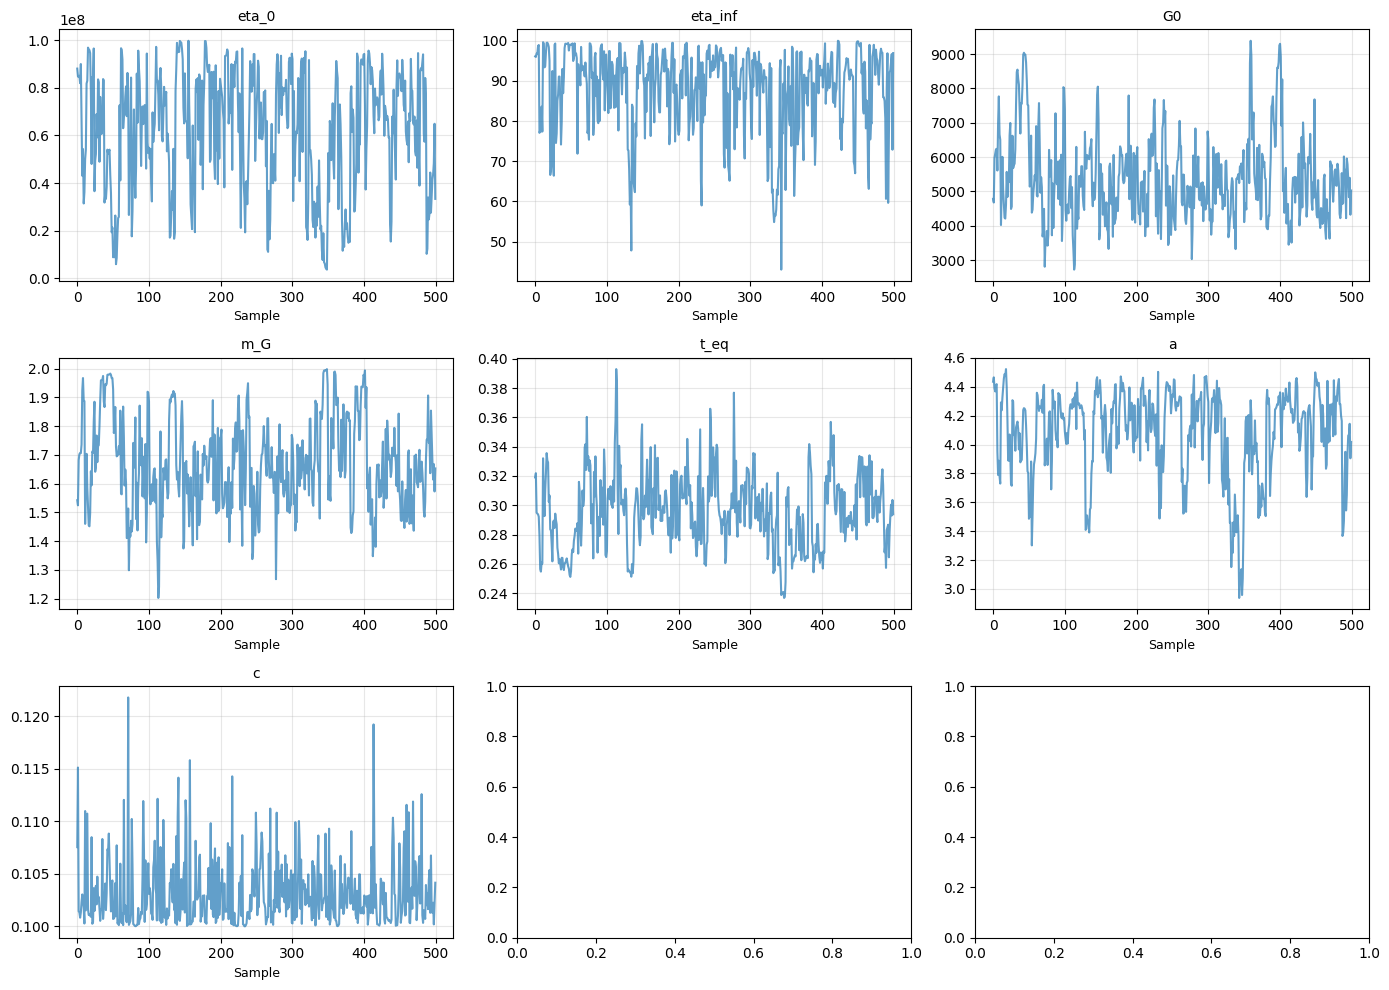


Note: Single chain used for computational efficiency
For production analysis, use num_chains=4, num_warmup=1000, num_samples=2000


In [16]:
# Run Bayesian inference with fast demo settings
# WARNING: This is still computationally intensive
try:
    result_bayes = model_fit.fit_bayesian(
        t_fit,
        stress_fit,
        test_mode="laos",
        num_warmup=200,      # Reduced from 1000
        num_samples=500,     # Reduced from 2000
        num_chains=1,        # Single chain for speed
        seed=42,
    )
    
    print("\nBayesian inference completed")
    
    # Brief diagnostics
    print("\nParameter estimates (posterior means):")
    for name, samples in result_bayes.posterior_samples.items():
        mean_val = np.mean(samples)
        std_val = np.std(samples)
        true_val = calib_params.get(name, None)
        if true_val is not None:
            error_pct = 100 * abs(mean_val - true_val) / true_val
            print(f"  {name}: {mean_val:.4e} ± {std_val:.4e} (true: {true_val:.4e}, error: {error_pct:.1f}%)")
        else:
            print(f"  {name}: {mean_val:.4e} ± {std_val:.4e}")
    
    # Quick trace plot
    fig, axes = plt.subplots(3, 3, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (name, samples) in enumerate(result_bayes.posterior_samples.items()):
        if idx >= 9:
            break
        ax = axes[idx]
        ax.plot(samples, alpha=0.7)
        ax.set_title(name, fontsize=10)
        ax.set_xlabel("Sample", fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig.savefig(output_dir / "laos_trace.png", dpi=300, bbox_inches="tight")
    display(fig)
    plt.close(fig)
    
    print("\nNote: Single chain used for computational efficiency")
    print("For production analysis, use num_chains=4, num_warmup=1000, num_samples=2000")
    
except Exception as e:
    print(f"\nBayesian inference failed or skipped: {e}")
    print("This is expected if computational resources are limited")

## Pipkin Diagram (Conceptual)

The Pipkin space maps the $(\gamma_0, \omega)$ parameter space into rheological regimes:

### Dimensionless Numbers

- **Deborah number**: $De = \lambda \omega$ (elasticity vs observation time)
- **Weissenberg number**: $Wi = \lambda \dot{\gamma}_0 = \lambda \gamma_0 \omega$ (elasticity vs deformation rate)

where $\lambda$ is a characteristic relaxation time.

### Regimes

1. **Linear Viscoelastic (LVE)**: Small $\gamma_0$, all $\omega$ → SAOS regime
2. **Quasi-Linear Nonlinear (QLN)**: Moderate $\gamma_0$, low $\omega$ → Weak nonlinearity
3. **Strongly Nonlinear**: Large $\gamma_0$, all $\omega$ → LAOS regime

### Interpretation

- **Vertical axis** ($\omega$): Probes different timescales
- **Horizontal axis** ($\gamma_0$): Controls nonlinearity
- **Diagonal lines** (constant $Wi$): Iso-deformation contours

For DMT models:
- LVE: $\gamma_0 < 0.1$ → Structure remains near equilibrium
- LAOS: $\gamma_0 > 0.5$ → Significant structure breakdown within each cycle

**Reference**: Hyun et al., "A review of nonlinear oscillatory shear tests", *J. Rheol.* **55**, 1 (2011).

## Save Results

In [17]:
# Save simulation data for each amplitude
for gamma_0 in amplitudes:
    data = steady_data[gamma_0]
    filename = output_dir / f"laos_gamma0_{gamma_0:.2f}.npz"
    np.savez(
        filename,
        t=data["t"],
        stress=data["stress"],
        strain=data["strain"],
        strain_rate=data["strain_rate"],
        lam=data["lam"],  # Fixed: key is 'lam' not 'lambda'
        gamma_0=gamma_0,
        omega=omega,
    )
    print(f"Saved data for γ₀ = {gamma_0:.2f} to {filename.name}")

# Save harmonics data
harmonics_summary = {
    "amplitudes": amplitudes,
    "nonlinearity_ratios": nonlinearity_ratios,
    "I1_values": I1_values,
    "I3_values": I3_values,
}
np.savez(output_dir / "harmonics_summary.npz", **harmonics_summary)
print(f"\nSaved harmonics summary to {output_dir / 'harmonics_summary.npz'}")

print(f"\nAll results saved to {output_dir.absolute()}")

Saved data for γ₀ = 0.01 to laos_gamma0_0.01.npz
Saved data for γ₀ = 0.10 to laos_gamma0_0.10.npz
Saved data for γ₀ = 0.50 to laos_gamma0_0.50.npz
Saved data for γ₀ = 2.00 to laos_gamma0_2.00.npz

Saved harmonics summary to outputs/dmt/laos/harmonics_summary.npz

All results saved to /Users/b80985/Projects/rheojax/examples/dmt/outputs/dmt/laos


## Key Takeaways

### LAOS as a Comprehensive Probe

1. **Elastic + Viscous + Structure**: LAOS simultaneously probes elastic, viscous, and structural kinetics
2. **Intra-cycle dynamics**: Structure evolves significantly within each oscillation cycle at large amplitudes
3. **Nonlinear signatures**: Lissajous distortion and higher harmonics reveal yielding and flow transitions

### Fourier Analysis

- **First harmonic** ($I_1$): Dominates in linear regime, analogous to SAOS moduli
- **Third harmonic** ($I_3$): Emerges in nonlinear regime, quantifies distortion
- **Nonlinearity ratio** ($I_3/I_1$): Sharp increase above critical strain amplitude

### Parameter Identifiability

- **All 7 parameters**: Potentially identifiable from LAOS waveform
- **Computational cost**: ODE integration over many cycles is expensive
- **Recommended workflow**: NLSQ warm-start → Multi-chain NUTS (production)

### Practical Considerations

- **Linear regime**: Use SAOS for efficient parameter estimation ($\gamma_0 \sim 0.01$)
- **Nonlinear regime**: LAOS reveals phenomena inaccessible to SAOS ($\gamma_0 \sim 1$)
- **Frequency sweep**: Combine with amplitude sweep for full Pipkin space coverage

### Next Steps

1. Explore **frequency dependence** of nonlinearity (vary $\omega$ at fixed $\gamma_0$)
2. Compare **closure models** (exponential vs Herschel-Bulkley) in LAOS
3. Investigate **sequential LAOS** (vary $\gamma_0$ stepwise to study history effects)
4. Apply to **experimental data** with calibrated priors from steady shear/SAOS